In [1]:
# HW9 — LLM 微調：情緒分類與憂鬱症風險監測
# ----------------------------------------------------
#
# 流程：
# 1. 載入並處理 'dair-ai/emotion' 資料集。
# 2. 建立從「情緒」到「憂鬱症風險」(低/中/高) 的映射。
# 3. 比較三種 LLM 方法：Zero-shot, Few-shot, QLoRA 微調。
# 4. 評估模型效能 (F1, AUROC, PR-AUC, 混淆矩陣)。
# 5. 視覺化呈現憂鬱症風險監測圖表。
#
# ----------------------------------------------------

###1. 環境設定與安裝

# - transformers: HuggingFace 的核心套件
# - datasets: 用於載入資料集
# - peft: (Parameter-Efficient Fine-Tuning) 用於 LoRA
# - accelerate: 用於加速模型訓練與推論
# - bitsandbytes: 用於 4-bit 量化 (QLoRA)
# - trl: (Transformer Reinforcement Learning) 包含易於使用的 SFTTrainer
# - scikit-learn, matplotlib, seaborn: 用於評估與視覺化


!pip install -q -U transformers datasets peft accelerate bitsandbytes trl scikit-learn matplotlib seaborn

2. 載入套件

In [2]:
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from datasets import load_dataset, Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    TrainingArguments,
    pipeline
)
from peft import LoraConfig, PeftModel, get_peft_model
from trl import SFTTrainer

from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    auc
)
from sklearn.preprocessing import label_binarize

3. 資料準備 (Data Preparation)

In [3]:

# --- 3.1 載入資料集 ---
dataset_name = "dair-ai/emotion"
dataset = load_dataset(dataset_name)

print(f"資料集 '{dataset_name}' 載入成功。")
print(dataset)

# --- 3.2 定義標籤與映射規則 ---

# 原始情緒標籤 (6類)
# 0: sadness
# 1: joy
# 2: love
# 3: anger
# 4: fear
# 5: surprise
emotion_labels = {
    0: "sadness",
    1: "joy",
    2: "love",
    3: "anger",
    4: "fear",
    5: "surprise"
}

# 倒轉 emotion_labels 以便從文字對應回 ID
emotion_labels_rev = {v: k for k, v in emotion_labels.items()}

# 風險標籤 (3類)
# 0: low_risk
# 1: mid_risk
# 2: high_risk
risk_labels = {
    0: "low_risk",
    1: "mid_risk",
    2: "high_risk"
}

# 定義從「情緒ID」到「風險ID」的映射函式
def map_emotion_to_risk(example):
    """
    joy/love/surprise (1, 2, 5) -> 0 = low_risk
    anger/fear (3, 4)           -> 1 = mid_risk
    sadness (0)                 -> 2 = high_risk
    """
    emotion_id = example['label']
    if emotion_id in [1, 2, 5]:
        example['risk_label'] = 0  # low_risk
    elif emotion_id in [3, 4]:
        example['risk_label'] = 1  # mid_risk
    elif emotion_id == 0:
        example['risk_label'] = 2  # high_risk
    return example

# --- 3.3 應用映射 ---
# 在所有資料集上 (train, validation, test) 應用此映射
mapped_dataset = dataset.map(map_emotion_to_risk)

print("\n已新增 'risk_label' 欄位。")
print("範例資料 (train):")
print(mapped_dataset['train'][0])

# --- 3.4 處理類別不平衡 (Oversampling) ---
print("\n--- 3.4 處理類別不平衡 (Oversampling) ---")

# 將 'train' 資料集轉為 pandas DataFrame 以便操作
train_df = mapped_dataset['train'].to_pandas()
label_counts = train_df['label'].value_counts()
print("Oversampling 前的訓練集類別分佈:")
print(label_counts)

# 找出少數類別：love(2), fear(4), surprise(5)
# 找出多數類別：sadness(0), joy(1), anger(3)
minority_labels = [2, 4, 5]
majority_labels = [0, 1, 3]

# 找出一個合理的目標數量 (例如，多數類別的平均值)
target_count = int(train_df[train_df['label'].isin(majority_labels)].shape[0] / len(majority_labels))
# 或是設定為第二大類別的數量
target_count = label_counts.sort_values(ascending=False).iloc[1] # e.g., ~4600 (sadness)
print(f"設定少數類別的目標樣本數為: {target_count}")

oversampled_dfs = [train_df[train_df['label'].isin(majority_labels)]] # 先加入所有多數類別

for label in minority_labels:
    minority_df = train_df[train_df['label'] == label]
    count = len(minority_df)

    # 使用 .sample(..., replace=True) 來過採樣
    oversampled_df = minority_df.sample(n=target_count, replace=True, random_state=42)
    oversampled_dfs.append(oversampled_df)
    print(f"將類別 {emotion_labels[label]} (n={count}) 過採樣至 {target_count} 筆")

# 合併所有 DataFrame
oversampled_train_df = pd.concat(oversampled_dfs)

# 將 oversampled DataFrame 轉回 HuggingFace Dataset
# 並打亂順序
oversampled_train_dataset = Dataset.from_pandas(oversampled_train_df).shuffle(seed=42)

print("\nOversampling 後的訓練集類別分佈:")
print(oversampled_train_dataset.to_pandas()['label'].value_counts())

# *** 關鍵：用過採樣的資料集覆蓋原來的訓練集 ***
mapped_dataset['train'] = oversampled_train_dataset

# --- 3.5 建立小型測試子集 ---
small_test_dataset = mapped_dataset['test'].shuffle(seed=42).select(range(200))

print(f"\n已建立 {len(small_test_dataset)} 筆資料的小型測試子集。")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


資料集 'dair-ai/emotion' 載入成功。
DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

已新增 'risk_label' 欄位。
範例資料 (train):
{'text': 'i didnt feel humiliated', 'label': 0, 'risk_label': 2}

--- 3.4 處理類別不平衡 (Oversampling) ---
Oversampling 前的訓練集類別分佈:
label
1    5362
0    4666
3    2159
4    1937
2    1304
5     572
Name: count, dtype: int64
設定少數類別的目標樣本數為: 4666
將類別 love (n=1304) 過採樣至 4666 筆
將類別 fear (n=1937) 過採樣至 4666 筆
將類別 surprise (n=572) 過採樣至 4666 筆

Oversampling 後的訓練集類別分佈:
label
1    5362
0    4666
4    4666
5    4666
2    4666
3    2159
Name: count, dtype: int64

已建立 200 筆資料的小型測試子集。


4. 模型與 Tokenizer 準備

In [4]:
# TinyLlama 是一個很好的選擇

print("\n=== 階段四：模型與 Tokenizer 準備 ===")

# --- 4.1 選擇模型 ---
model_name = "TinyLlama/TinyLlama-1.1B-Chat-v1.0"
# model_name = "google/gemma-2b-it" # 備選方案

print(f"選用模型: {model_name}")

# --- 4.2 載入 Tokenizer ---
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# LLM 模型通常沒有預設的 padding token，我們將其設為 end-of-sentence token
tokenizer.pad_token = tokenizer.eos_token


=== 階段四：模型與 Tokenizer 準備 ===
選用模型: TinyLlama/TinyLlama-1.1B-Chat-v1.0


5. 方法一 & 二 (Zero-shot & Few-shot 推論)

In [5]:
# 先載入一個未經微調的 4-bit 量化模型來執行推論

# --- 5.1 載入 4-bit 量化模型 (用於推論) ---
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

base_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map="auto", # 自動分配到 GPU
    trust_remote_code=True,
)

# 使用 HuggingFace pipeline 簡化推論
pipe = pipeline(
    "text-generation",
    model=base_model,
    tokenizer=tokenizer,
    max_new_tokens=10,  # 我們只需要模型回答一個詞 (如 'sadness')
    temperature=0.1
)

# --- 5.2 輔助函式：解析模型輸出 ---
def parse_emotion_output(text):
    """ 從模型的完整輸出中解析出情緒關鍵字 """
    text = text.lower()
    for label_text in emotion_labels_rev.keys():
        if label_text in text:
            return label_text
    return "unknown" # 如果都沒對應到

# --- 5.3 方法一：Zero-shot 推論 ---
print("\n--- 5.3 開始 Zero-shot 推論 ---")

def create_zero_shot_prompt(text):
    """
    建立 Zero-shot 提示詞。
    TinyLlama-Chat 模型的提示詞格式為：
    <|system|>
    You are a helpful assistant.</s>
    <|user|>
    {prompt}</s>
    <|assistant|>
    """
    system_prompt = "You are an expert in text classification. Classify the emotion of the following text. The possible emotions are: joy, love, surprise, anger, fear, sadness."
    user_prompt = f"Text: {text}\nEmotion:"

    # 使用 tokenizer.apply_chat_template 來正確格式化
    chat = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]
    prompt = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
    return prompt

zero_shot_predictions_text = []
true_labels_emotion_text = []

for example in small_test_dataset:
    prompt = create_zero_shot_prompt(example['text'])
    # 執行推論
    result = pipe(prompt)
    generated_text = result[0]['generated_text']

    # 解析 <|assistant|> 之後的內容
    assistant_response = generated_text.split("<|assistant|>")[-1].strip()

    # 解析情緒
    predicted_emotion = parse_emotion_output(assistant_response)
    zero_shot_predictions_text.append(predicted_emotion)
    true_labels_emotion_text.append(emotion_labels[example['label']])

print(f"Zero-shot 推論完成。範例 0 預測: '{zero_shot_predictions_text[0]}', 實際: '{true_labels_emotion_text[0]}'")

# --- 5.4 方法二：Few-shot 推論 ---
print("\n--- 5.4 開始 Few-shot 推論 ---")

# 我們從訓練集中挑選 5 個清晰的範例
few_shot_examples = """
Text: i feel so sad and lonely
Emotion: sadness
Text: i am feeling amazing and joyful today
Emotion: joy
Text: i am really angry at what you said
Emotion: anger
Text: i feel terrified of the dark
Emotion: fear
Text: i was so surprised to see her
Emotion: surprise
"""

def create_few_shot_prompt(text):
    """ 建立 Few-shot 提示詞 """
    system_prompt = "You are an expert in text classification. Classify the emotion of the following text based on the examples provided. The possible emotions are: joy, love, surprise, anger, fear, sadness."
    user_prompt = f"{few_shot_examples}\nText: {text}\nEmotion:"

    chat = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt}
    ]
    prompt = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
    return prompt

few_shot_predictions_text = []

for example in small_test_dataset:
    prompt = create_few_shot_prompt(example['text'])
    # 執行推論
    result = pipe(prompt)
    generated_text = result[0]['generated_text']

    # 解析 <|assistant|> 之後的內容
    assistant_response = generated_text.split("<|assistant|>")[-1].strip()

    # 解析情緒
    predicted_emotion = parse_emotion_output(assistant_response)
    few_shot_predictions_text.append(predicted_emotion)

print(f"Few-shot 推論完成。範例 0 預測: '{few_shot_predictions_text[0]}', 實際: '{true_labels_emotion_text[0]}'")

# 釋放 GPU 記憶體，準備 LoRA 訓練
del base_model
del pipe
torch.cuda.empty_cache()

Device set to use cuda:0



--- 5.3 開始 Zero-shot 推論 ---


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Zero-shot 推論完成。範例 0 預測: 'sadness', 實際: 'sadness'

--- 5.4 開始 Few-shot 推論 ---
Few-shot 推論完成。範例 0 預測: 'unknown', 實際: 'sadness'


6. 方法三 (QLoRA 微調)

In [9]:

# --- 6.1 資料格式化 (用於 SFTTrainer) ---
# SFTTrainer (Supervised Fine-Tuning Trainer) 需要特定格式的資料
# 我們將資料轉換為提示詞格式

def format_instruction(example):
    # 我們使用與 Zero-shot 類似的提示詞結構，但這次提供了答案
    # 注意：我們直接訓練模型預測「情緒文字」，而不是 ID

    emotion_text = emotion_labels[example['label']]

    system_prompt = "You are an expert in text classification. Classify the emotion of the following text. The possible emotions are: joy, love, surprise, anger, fear, sadness."
    user_prompt = f"Text: {example['text']}\nEmotion:"

    chat = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_prompt},
        {"role": "assistant", "content": emotion_text} # 這是要學習的答案
    ]
    # 回傳 "text" 欄位，SFTTrainer 會自動處理
    formatted_prompt = tokenizer.apply_chat_template(chat, tokenize=False)

    # SFTTrainer 的 'text' 欄位是預設的
    return {"text": formatted_prompt}


# 格式化訓練集和驗證集
# 使用 .map()
formatted_train_dataset = mapped_dataset['train'].map(format_instruction)
formatted_validation_dataset = mapped_dataset['validation'].map(format_instruction)

print("\nSFTTrainer 資料格式化完成。")
# 檢查 'text' 欄位是否存在
print(formatted_train_dataset[0]['text'])

# --- 6.2 載入 4-bit 模型 (用於訓練) ---
bnb_config_train = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

lora_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config_train,
    device_map="auto",
    trust_remote_code=True,
)
lora_model.config.use_cache = False # 訓練時關閉快取
# 【新版】設定 pretraining_tp=1 以修復 parallel issue
lora_model.config.pretraining_tp = 1


# --- 6.3 LoRA 設定 ---
lora_config = LoraConfig(
    r=32, # 增加 Rank，提升學習容量
    # lora_alpha=32, # Alpha
    lora_alpha=64, # Alpha 通常設為 r 的 2 倍
    lora_dropout=0.05,
    # 針對 TinyLlama 中更多的層，以提升學習效果
    target_modules=[
        "q_proj",
        "v_proj",
        "k_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj"
    ],
    bias="none",
    task_type="CAUSAL_LM",
)

# --- 6.4 訓練參數設定 ---
training_args = TrainingArguments(
    output_dir="./lora_finetune_results",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    learning_rate=2e-4,
    num_train_epochs=2, # 我們要訓練 2 個 epochs
    metric_for_best_model="eval_loss", # 以驗證集的 loss 為標準
    logging_steps=100, # 每 100 步 log 一次
    fp16=True, # 使用混合精度

)


# --- 6.5 初始化 SFTTrainer ---
trainer = SFTTrainer(
    model=lora_model,
    args=training_args,
    peft_config=lora_config,
    train_dataset=formatted_train_dataset,
    eval_dataset=formatted_validation_dataset,
)

print("\n--- 6.5 SFTTrainer 初始化完成，開始訓練 ---")

# --- 6.6 開始訓練 ---
train_result = trainer.train()

print("--- 訓練完成 ---")

# --- 6.7 儲存模型 ---
output_dir = "./lora_finetuned_model"
trainer.save_model(output_dir)
print(f"模型已儲存至 {output_dir}")

# --- 6.8 LoRA 推論 ---
# 釋放訓練佔用的記憶體
del lora_model
del trainer
torch.cuda.empty_cache()

# 載入微調後的模型 (Adapter)
finetuned_model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config, # 同樣使用 4-bit 載入
    device_map="auto",
    trust_remote_code=True
)

# 載入 LoRA 權重
finetuned_model = PeftModel.from_pretrained(finetuned_model, output_dir)
finetuned_model = finetuned_model.merge_and_unload() # 合併權重以便推論

print("\n--- 6.8 已載入微調後的 LoRA 模型，準備推論 ---")

# 建立推論 pipeline
lora_pipe = pipeline(
    "text-generation",
    model=finetuned_model,
    tokenizer=tokenizer,
    max_new_tokens=10,
    temperature=0.1
)

# 在「小型測試子集」上進行推論 (用於方法比較)
lora_predictions_text = []

# 我們使用與 Zero-shot 相同的提示詞，來測試微調後的效果
for example in small_test_dataset:
    prompt = create_zero_shot_prompt(example['text']) # 注意：使用 zero-shot 提示詞
    result = lora_pipe(prompt)
    generated_text = result[0]['generated_text']
    assistant_response = generated_text.split("<|assistant|>")[-1].strip()
    predicted_emotion = parse_emotion_output(assistant_response)
    lora_predictions_text.append(predicted_emotion)

print(f"LoRA (small_test_set) 推論完成。範例 0 預測: '{lora_predictions_text[0]}', 實際: '{true_labels_emotion_text[0]}'")

# 在「完整測試集」上進行推論 (用於最終評估與視覺化)
print("\n--- 6.9 在完整 2000 筆測試集上進行 LoRA 推論 (這可能需要幾分鐘) ---")
lora_full_predictions_text = []
true_full_labels_emotion = []
true_full_labels_risk = []

for example in mapped_dataset['test']:
    prompt = create_zero_shot_prompt(example['text'])
    result = lora_pipe(prompt)
    generated_text = result[0]['generated_text']
    assistant_response = generated_text.split("<|assistant|>")[-1].strip()

    predicted_emotion = parse_emotion_output(assistant_response)
    lora_full_predictions_text.append(predicted_emotion)
    true_full_labels_emotion.append(example['label'])
    true_full_labels_risk.append(example['risk_label'])

print("LoRA (full_test_set) 推論完成。")

Map:   0%|          | 0/26185 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]


SFTTrainer 資料格式化完成。
<|system|>
You are an expert in text classification. Classify the emotion of the following text. The possible emotions are: joy, love, surprise, anger, fear, sadness.</s>
<|user|>
Text: i feel very happy to have inspired is my little sis love of reading and writing
Emotion:</s>
<|assistant|>
joy</s>



Adding EOS to train dataset:   0%|          | 0/26185 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/26185 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/26185 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/2000 [00:00<?, ? examples/s]

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'pad_token_id': 2}.



--- 6.5 SFTTrainer 初始化完成，開始訓練 ---


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yujung (yujung-national-chung-hsing-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
100,0.792500
200,0.741500
300,0.709200
400,0.690300
500,0.680600
600,0.663100
700,0.636000
800,0.616200
900,0.611200
1000,0.587100


--- 訓練完成 ---
模型已儲存至 ./lora_finetuned_model


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/bnb.py:348: UserWarning: Merge lora module to 4-bit linear may get different generations due to rounding errors.
  warnings.warn(
Device set to use cuda:0



--- 6.8 已載入微調後的 LoRA 模型，準備推論 ---
LoRA (small_test_set) 推論完成。範例 0 預測: 'sadness', 實際: 'sadness'

--- 6.9 在完整 2000 筆測試集上進行 LoRA 推論 (這可能需要幾分鐘) ---
LoRA (full_test_set) 推論完成。


7. 效能評估與比較

--------------------------------------------------

--- 方法一：Zero-shot (n=200) 評估報告 ---

[情緒分類 (6-class)]
              precision    recall  f1-score   support

     sadness       0.56      0.20      0.29        25
         joy       0.49      0.97      0.66        40
        love       0.00      0.00      0.00         6
       anger       0.00      0.00      0.00         5
        fear       0.00      0.00      0.00        11
    surprise       0.00      0.00      0.00         3

    accuracy                           0.49        90
   macro avg       0.17      0.20      0.16        90
weighted avg       0.37      0.49      0.37        90


[風險分類 (3-class)]
              precision    recall  f1-score   support

    low_risk       0.59      0.96      0.73        49
    mid_risk       0.50      0.06      0.11        16
   high_risk       0.56      0.20      0.29        25

    accuracy                           0.59        90
   macro avg       0.55      0.41      0.38        90
weighted

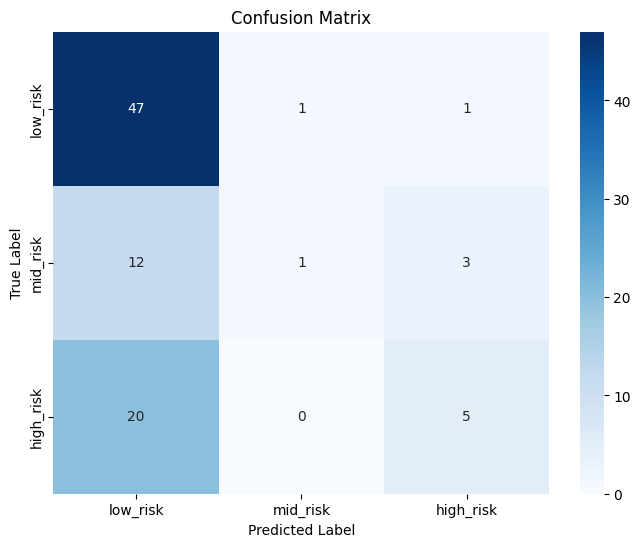

--------------------------------------------------

--- 方法二：Few-shot (n=200) 評估報告 ---

[情緒分類 (6-class)]
              precision    recall  f1-score   support

     sadness       0.00      0.00      0.00         5
         joy       0.71      0.86      0.77        14
        love       1.00      1.00      1.00         1
       anger       0.00      0.00      0.00         1
        fear       0.00      0.00      0.00         1
    surprise       0.40      1.00      0.57         2

    accuracy                           0.62        24
   macro avg       0.35      0.48      0.39        24
weighted avg       0.49      0.62      0.54        24


[風險分類 (3-class)]
              precision    recall  f1-score   support

    low_risk       0.74      1.00      0.85        17
    mid_risk       1.00      0.50      0.67         2
   high_risk       0.00      0.00      0.00         5

    accuracy                           0.75        24
   macro avg       0.58      0.50      0.51        24
weighted 

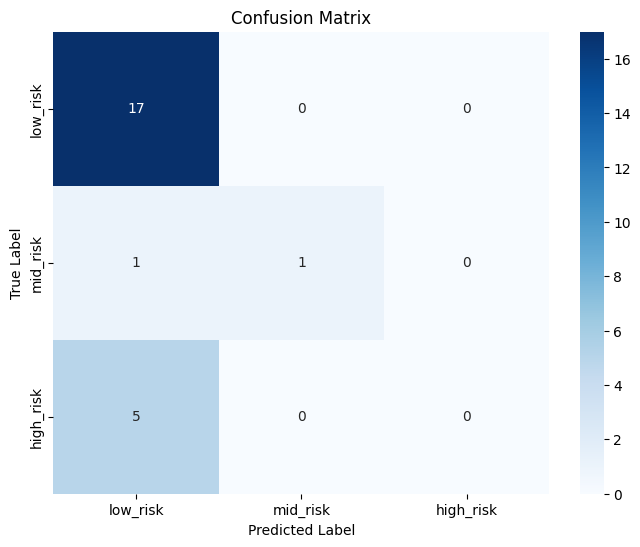

--------------------------------------------------

--- 方法三：QLoRA (n=200) 評估報告 ---

[情緒分類 (6-class)]
              precision    recall  f1-score   support

     sadness       0.95      0.91      0.93        58
         joy       0.97      0.90      0.94        83
        love       0.67      0.77      0.71        13
       anger       0.72      0.95      0.82        19
        fear       0.79      0.86      0.83        22
    surprise       0.67      0.40      0.50         5

    accuracy                           0.89       200
   macro avg       0.79      0.80      0.79       200
weighted avg       0.89      0.89      0.89       200


[風險分類 (3-class)]
              precision    recall  f1-score   support

    low_risk       0.99      0.93      0.96       101
    mid_risk       0.80      0.95      0.87        41
   high_risk       0.95      0.91      0.93        58

    accuracy                           0.93       200
   macro avg       0.91      0.93      0.92       200
weighted avg

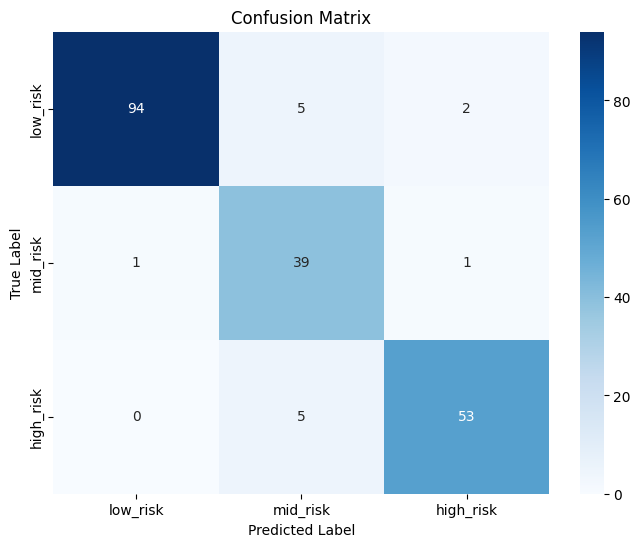


--- [三種方法比較 (n=200, 風險分類)] ---
| Method    |   F1 (Macro) |   AUROC |   PR-AUC |
|:----------|-------------:|--------:|---------:|
| Zero-shot |       0.3799 |  0.5610 |   0.5472 |
| Few-shot  |       0.5056 |  0.6071 |   0.7482 |
| QLoRA     |       0.9186 |  0.9503 |   0.9329 |
--------------------------------------------------

--- 方法三：QLoRA (完整測試集 n=2000) 評估報告 ---

[情緒分類 (6-class)]
              precision    recall  f1-score   support

     sadness       0.93      0.94      0.94       581
         joy       0.92      0.91      0.91       695
        love       0.74      0.78      0.76       159
       anger       0.89      0.86      0.88       275
        fear       0.83      0.94      0.88       224
    surprise       0.90      0.58      0.70        66

    accuracy                           0.89      2000
   macro avg       0.87      0.83      0.85      2000
weighted avg       0.90      0.89      0.89      2000


[風險分類 (3-class)]
              precision    recall  f1-score   sup

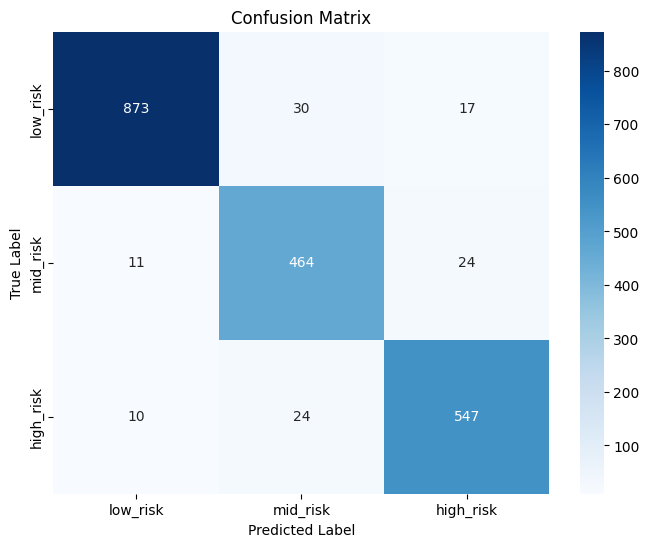

(0.93694803038635, 0.9559898203317799, np.float64(0.9467980068613523))

In [10]:
# --- 7.1 評估輔助函式 ---

def plot_confusion_matrix(y_true, y_pred, labels):
    """ 繪製混淆矩陣 """
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(labels))))
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

def calculate_multiclass_auc(y_true, y_pred_text, labels_dict):
    """ 計算多分類的 AUROC 和 PR-AUC """
    labels = list(labels_dict.keys())
    labels_text = list(labels_dict.values())

    # 將文字預測轉換為 ID
    y_pred = [labels[labels_text.index(p)] if p in labels_text else -1 for p in y_pred_text]

    # 處理 'unknown' 預測 (將其從評估中排除)
    valid_indices = [i for i, p in enumerate(y_pred) if p != -1]
    y_true_valid = [y_true[i] for i in valid_indices]
    y_pred_valid = [y_pred[i] for i in valid_indices]

    if len(y_true_valid) == 0:
        print("所有預測均為 'unknown'，無法評估。")
        return None, None, y_true_valid, y_pred_valid

    # Binarize a 假的 y_score (因為 LLM 只輸出類別)
    # 嚴格來說，沒有機率分數的 AUROC / PR-AUC 意義有限
    # 但作業要求，我們這裡假設模型輸出的類別是 100% 確定的
    y_score = label_binarize(y_pred_valid, classes=labels)
    y_true_bin = label_binarize(y_true_valid, classes=labels)

    # 計算 AUROC (One-vs-Rest)
    try:
        auroc = roc_auc_score(y_true_bin, y_score, multi_class='ovr', average='macro')
    except ValueError as e:
        print(f"計算 AUROC 失敗: {e}")
        auroc = 0.0

    # 計算 PR-AUC (Macro)
    pr_auc_scores = []
    for i in range(len(labels)):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_score[:, i])
        pr_auc_scores.append(auc(recall, precision))
    pr_auc = np.mean(pr_auc_scores)

    return auroc, pr_auc, y_true_valid, y_pred_valid

def evaluate_model(y_true_emotion, y_pred_emotion_text, y_true_risk, title):
    """ 綜合評估函式 (情緒 + 風險) """
    print(f"\n--- {title} 評估報告 ---")

    # --- 1. 情緒分類 (6-class) 評估 ---
    print("\n[情緒分類 (6-class)]")

    # 將 y_true_emotion (ID) 轉為文字
    y_true_emotion_text = [emotion_labels[i] for i in y_true_emotion]

    # 處理 'unknown' 預測
    valid_indices = [i for i, p in enumerate(y_pred_emotion_text) if p != "unknown"]
    if len(valid_indices) == 0:
        print("所有預測均為 'unknown'，無法評估。")
        return

    y_true_valid = [y_true_emotion_text[i] for i in valid_indices]
    y_pred_valid = [y_pred_emotion_text[i] for i in valid_indices]

    labels_text = list(emotion_labels.values())

    print(classification_report(y_true_valid, y_pred_valid, labels=labels_text, zero_division=0))

    # --- 2. 風險分類 (3-class) 評估 ---
    print("\n[風險分類 (3-class)]")

    # 將情緒預測轉換為風險預測
    risk_map = {
        "joy": "low_risk", "love": "low_risk", "surprise": "low_risk",
        "anger": "mid_risk", "fear": "mid_risk",
        "sadness": "high_risk",
        "unknown": "unknown"
    }
    y_pred_risk_text = [risk_map.get(p, "unknown") for p in y_pred_emotion_text]
    y_true_risk_text = [risk_labels[i] for i in y_true_risk]

    # 處理 'unknown'
    valid_indices_risk = [i for i, p in enumerate(y_pred_risk_text) if p != "unknown"]
    y_true_risk_valid = [y_true_risk_text[i] for i in valid_indices_risk]
    y_pred_risk_valid = [y_pred_risk_text[i] for i in valid_indices_risk]

    risk_labels_text_list = list(risk_labels.values())

    print(classification_report(y_true_risk_valid, y_pred_risk_valid, labels=risk_labels_text_list, zero_division=0))

    # 計算 F1
    f1_macro = f1_score(y_true_risk_valid, y_pred_risk_valid, average='macro', zero_division=0)

    # 計算 AUROC 和 PR-AUC (基於 ID)
    y_true_risk_ids = [y_true_risk[i] for i in valid_indices_risk]
    y_pred_risk_ids = [list(risk_labels.values()).index(p) for p in y_pred_risk_valid]

    y_true_bin = label_binarize(y_true_risk_ids, classes=[0, 1, 2])
    y_score_bin = label_binarize(y_pred_risk_ids, classes=[0, 1, 2])

    try:
        auroc = roc_auc_score(y_true_bin, y_score_bin, multi_class='ovr', average='macro')
    except ValueError as e:
        auroc = 0.0
        print(f"計算 AUROC 失敗: {e}")

    pr_auc_scores = []
    for i in range(3):
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_score_bin[:, i])
        pr_auc_scores.append(auc(recall, precision))
    pr_auc = np.mean(pr_auc_scores)

    print(f"F1 (Macro): {f1_macro:.4f}")
    print(f"AUROC (Macro OVR): {auroc:.4f}")
    print(f"PR-AUC (Macro): {pr_auc:.4f}")

    # 繪製混淆矩陣 (風險分類)
    plot_confusion_matrix([list(risk_labels.values()).index(t) for t in y_true_risk_valid],
                          y_pred_risk_ids,
                          risk_labels_text_list)

    return f1_macro, auroc, pr_auc


# --- 7.2 執行小型測試集的比較 ---
# 獲取小型測試集的真實標籤
small_test_true_emotion = small_test_dataset['label']
small_test_true_risk = small_test_dataset['risk_label']

# 評估 Zero-shot
print("-" * 50)
f1_zero, auc_zero, pr_zero = evaluate_model(
    small_test_true_emotion,
    zero_shot_predictions_text,
    small_test_true_risk,
    "方法一：Zero-shot (n=200)"
)

# 評估 Few-shot
print("-" * 50)
f1_few, auc_few, pr_few = evaluate_model(
    small_test_true_emotion,
    few_shot_predictions_text,
    small_test_true_risk,
    "方法二：Few-shot (n=200)"
)

# 評估 LoRA
print("-" * 50)
f1_lora, auc_lora, pr_lora = evaluate_model(
    small_test_true_emotion,
    lora_predictions_text, # 使用在 small_test_set 上的預測
    small_test_true_risk,
    "方法三：QLoRA (n=200)"
)

# --- 7.3 比較表格 ---
print("\n--- [三種方法比較 (n=200, 風險分類)] ---")
comparison_data = {
    "Method": ["Zero-shot", "Few-shot", "QLoRA"],
    "F1 (Macro)": [f1_zero, f1_few, f1_lora],
    "AUROC": [auc_zero, auc_few, auc_lora],
    "PR-AUC": [pr_zero, pr_few, pr_lora]
}
comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_markdown(index=False, floatfmt=".4f"))


# --- 7.4 評估 LoRA (完整測試集) ---
# 這是我們最終的模型效能報告
print("-" * 50)
evaluate_model(
    true_full_labels_emotion,
    lora_full_predictions_text,
    true_full_labels_risk,
    "方法三：QLoRA (完整測試集 n=2000)"
)

8. 風險監測視覺化

In [11]:
# Colab 進行matplotlib繪圖時顯示繁體中文
# 下載台北思源黑體並命名taipei_sans_tc_beta.ttf，移至指定路徑
!wget -O TaipeiSansTCBeta-Regular.ttf https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_&export=download

import matplotlib

# 改style要在改font之前
# plt.style.use('seaborn')

matplotlib.font_manager.fontManager.addfont('TaipeiSansTCBeta-Regular.ttf')
matplotlib.rc('font', family='Taipei Sans TC Beta')

--2025-11-13 12:42:35--  https://drive.google.com/uc?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.google.com (drive.google.com)... 142.250.141.102, 142.250.141.113, 142.250.141.138, ...
Connecting to drive.google.com (drive.google.com)|142.250.141.102|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_ [following]
--2025-11-13 12:42:35--  https://drive.usercontent.google.com/download?id=1eGAsTN1HBpJAkeVM57_C7ccp7hbgSz3_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.2.132, 2607:f8b0:4023:c0d::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.2.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20659344 (20M) [application/octet-stream]
Saving to: ‘TaipeiSansTCBeta-Regular.ttf’

TaipeiSansTCBeta-Re 100%[===================>]  19.70M  58.7MB/s    in 0.3s    

2025-11-13 12:4

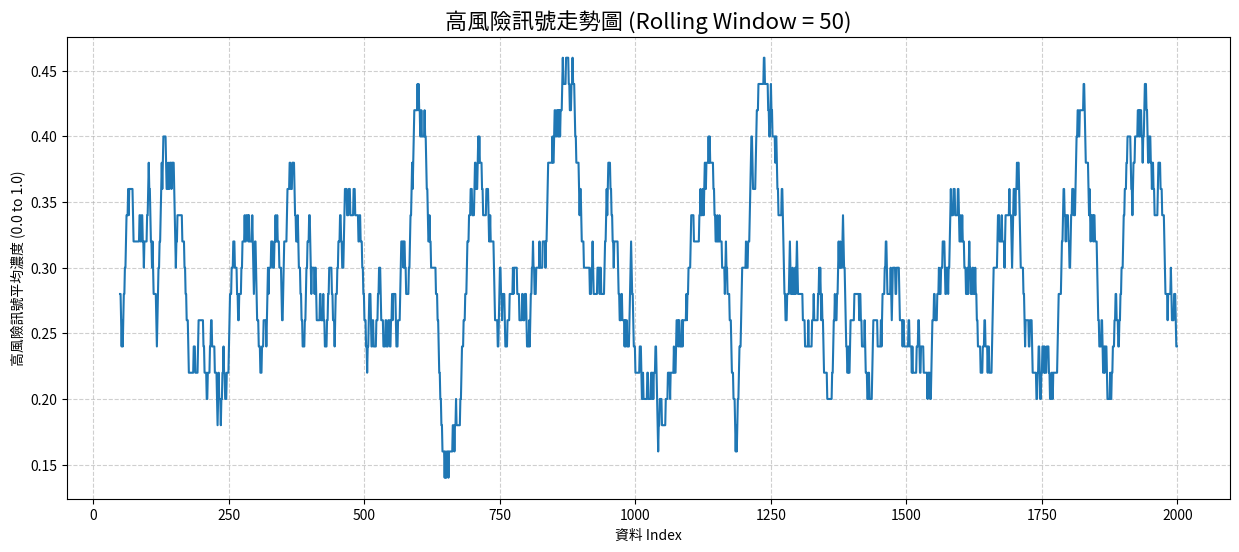

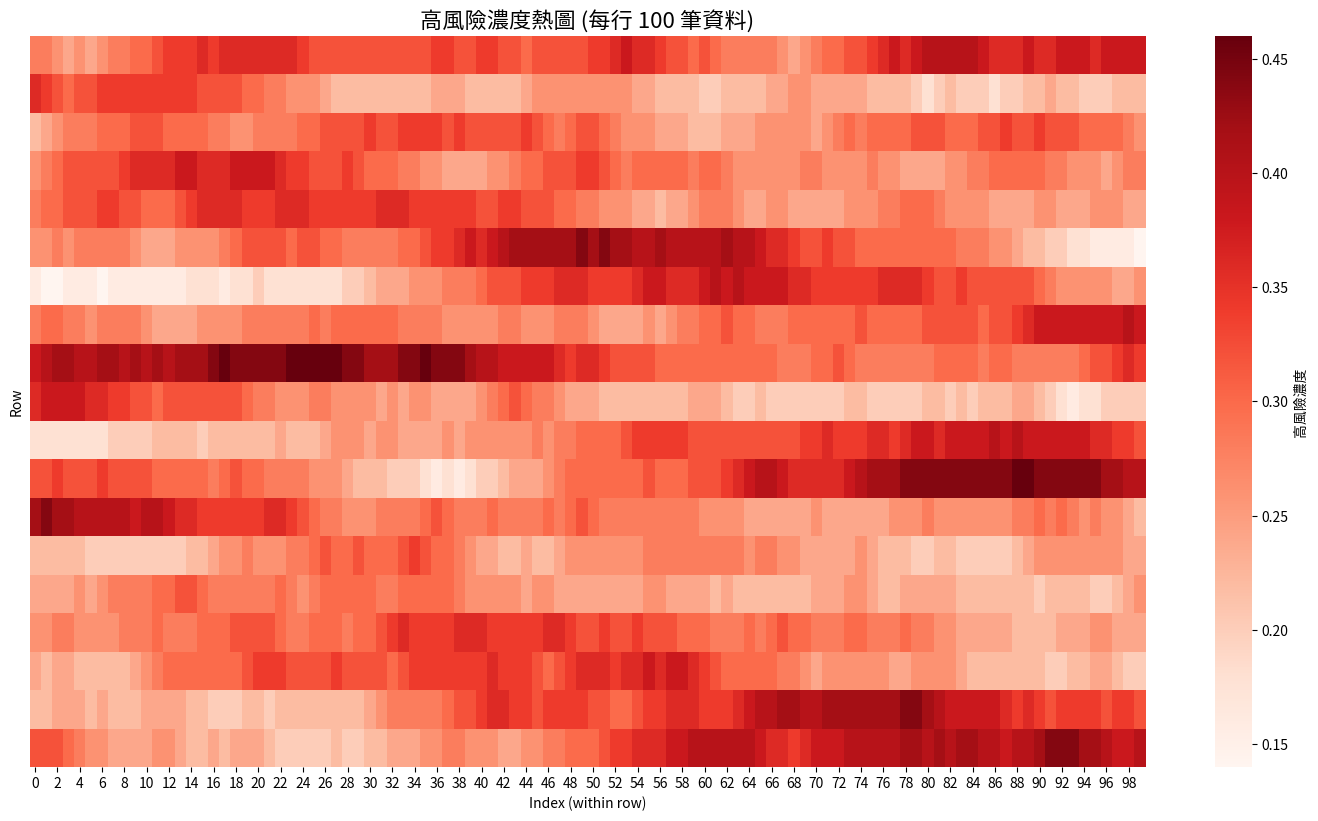


--- 作業流程結束 ---


In [12]:
# 我們將使用 LoRA 在完整測試集 (n=2000) 上的預測結果


# --- 8.1 資料準備 ---
# 將情緒預測轉為風險 ID
risk_map_text_to_id = {
    "joy": 0, "love": 0, "surprise": 0,
    "anger": 1, "fear": 1,
    "sadness": 2,
    "unknown": -1 # 標記為 -1
}

# 獲取 LoRA 在完整測試集上的風險預測 (ID)
lora_full_predictions_risk_id = [risk_map_text_to_id.get(p, -1) for p in lora_full_predictions_text]

# 建立一個 DataFrame
vis_df = pd.DataFrame({
    'index': range(len(lora_full_predictions_risk_id)),
    'true_risk': true_full_labels_risk,
    'pred_risk': lora_full_predictions_risk_id,
    'is_high_risk': [1 if r == 2 else 0 for r in lora_full_predictions_risk_id] # 預測是否為高風險
})

# 排除 'unknown' 預測
vis_df = vis_df[vis_df['pred_risk'] != -1].copy()

# --- 8.2 高風險走勢圖 (Rolling Window) ---
# 畫出高風險訊號 (is_high_risk) 的滾動平均值
window_size = 50
vis_df['high_risk_rolling'] = vis_df['is_high_risk'].rolling(window=window_size).mean()

plt.figure(figsize=(15, 6))
vis_df['high_risk_rolling'].plot()
plt.title(f'高風險訊號走勢圖 (Rolling Window = {window_size})', fontsize=16)
plt.xlabel('資料 Index')
plt.ylabel('高風險訊號平均濃度 (0.0 to 1.0)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# --- 8.3 高風險濃度熱圖 ---
# 我們將滾動平均值轉換為一個 2D 陣列以便繪製熱圖
rolling_data = vis_df['high_risk_rolling'].dropna().values

# 為了製作熱圖，我們將 1D 陣列重塑
# 例如，每 100 個點一行
step = 100
num_rows = len(rolling_data) // step
if num_rows == 0:
    print("資料點不足以繪製熱圖。")
else:
    heatmap_data = rolling_data[:num_rows * step].reshape((num_rows, step))

    plt.figure(figsize=(18, num_rows * 0.5)) # 讓熱圖扁平
    sns.heatmap(
        heatmap_data,
        cmap="Reds", # 使用紅色系
        cbar=True,
        cbar_kws={'label': '高風險濃度'}
    )
    plt.title('高風險濃度熱圖 (每行 100 筆資料)', fontsize=16)
    plt.xlabel('Index (within row)')
    plt.ylabel('Row')
    plt.yticks([]) # 隱藏 Y 軸標籤
    plt.show()

print("\n--- 作業流程結束 ---")